# Freecodecamp Challenge - Health Costs Prediction
## with Linear Regression

In [1]:
# Import libraries. You may or may not use all of these.
# %pip install -q git+https://github.com/tensorflow/docs or %pip install tensorflow_docs
# Use seaborn for pairplot.
# %pip install -q seaborn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf # tensorflow 2.16.1
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [2]:
# Import data
# !wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


## Data Preprocessing

In [3]:
print(dataset.isna().sum()) # check the number of nan values
dataset = dataset.dropna() # drop nan rows if it exists

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64


In [4]:
# convert categorical columns to numeric values
categorical_cols=['sex', 'smoker', 'region']

for categorical_col in categorical_cols:
    dataset[categorical_col] = dataset[categorical_col].map({'male':'male', 'yes': 'smoker', 'northeast':'NE', 'southeast':'SE', 'southwest':'SW', 'northwest':'NW'})
    dataset = pd.get_dummies(dataset, columns=[categorical_col], prefix='', prefix_sep='')

dataset.tail()

,age,bmi,children,expenses,male,smoker,NE,NW,SE,SW
1333,50,31.0,3,10600.55,True,False,False,True,False,False
1334,18,31.9,0,2205.98,False,False,True,False,False,False
1335,18,36.9,0,1629.83,False,False,False,False,True,False
1336,21,25.8,0,2007.95,False,False,False,False,False,True
1337,61,29.1,0,29141.36,False,True,False,True,False,False


In [5]:
# split the dataset in two
# train_dataset = dataset.sample(frac=0.8, random_state=0) # shuffle and split in one line
train_dataset = dataset[:1070]
test_dataset = dataset.drop(train_dataset.index)

# create feature datasets
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# create labels datasets
train_labels, test_labels = train_features.pop('expenses'), test_features.pop('expenses')

# shuffle train_features for validation data
shuffled_train_dataset = train_dataset.copy().reindex(np.random.permutation(train_dataset.index))
shuffled_train_features = shuffled_train_dataset
shuffled_train_labels = shuffled_train_features.pop('expenses')

## Inspecting the Data
Review the joint distribution of a few pairs of columns from the training set.

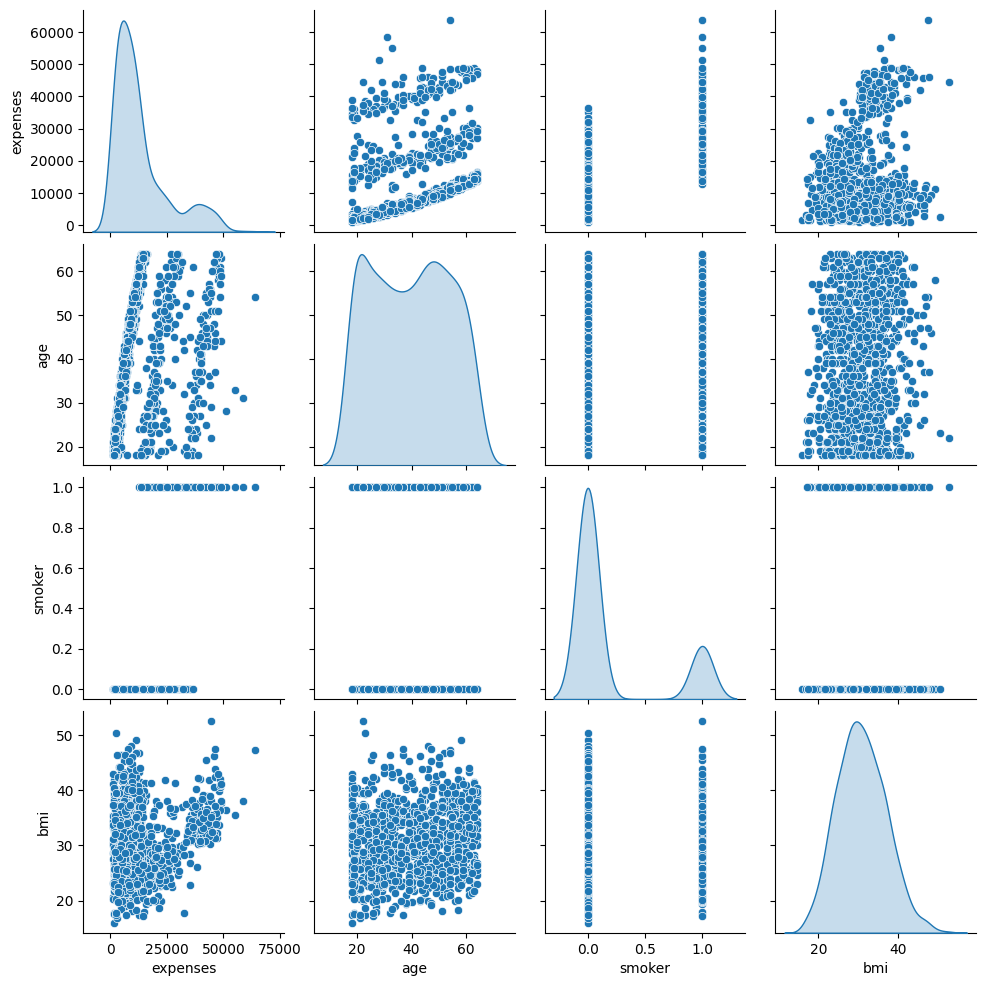

In [6]:
sns.pairplot(train_dataset[['expenses', 'age', 'smoker', 'bmi']], diag_kind='kde')

In [7]:
train_features

,age,bmi,children,male,smoker,NE,NW,SE,SW
0,19,27.9,0,False,True,False,False,False,True
1,18,33.8,1,True,False,False,False,True,False
2,28,33.0,3,True,False,False,False,True,False
3,33,22.7,0,True,False,False,True,False,False
4,32,28.9,0,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...
1065,42,25.3,1,False,False,False,False,False,True
1066,48,37.3,2,True,False,False,False,True,False
1067,39,42.7,0,True,False,True,False,False,False
1068,63,21.7,1,True,False,False,True,False,False


In [8]:
train_labels

0       16884.92
1        1725.55
2        4449.46
3       21984.47
4        3866.86
          ...   
1065     7045.50
1066     8978.19
1067     5757.41
1068    14349.85
1069    10928.85
Name: expenses, Length: 1070, dtype: float64

In [9]:
shuffled_train_features

,age,bmi,children,male,smoker,NE,NW,SE,SW
814,36,34.4,2,True,False,False,False,True,False
383,35,43.3,2,False,False,False,False,True,False
930,26,46.5,1,True,False,False,False,True,False
714,24,22.6,0,False,False,False,False,False,True
653,45,36.3,2,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...
762,33,27.1,1,True,True,False,False,False,True
589,38,30.7,1,False,False,False,False,True,False
270,18,29.4,1,True,False,False,False,True,False
367,42,25.0,2,False,False,False,True,False,False


In [10]:
shuffled_train_labels

814     5584.31
383     5846.92
930     2927.06
714     2457.50
653     8527.53
         ...   
762    19040.88
589     5976.83
270     1719.44
367     8017.06
839    12622.18
Name: expenses, Length: 1070, dtype: float64

In [11]:
test_features

,age,bmi,children,male,smoker,NE,NW,SE,SW
1070,37,37.1,1,True,True,False,False,True,False
1071,63,31.4,0,True,False,True,False,False,False
1072,21,31.3,0,True,False,False,True,False,False
1073,54,28.9,2,False,False,True,False,False,False
1074,60,18.3,0,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,31.0,3,True,False,False,True,False,False
1334,18,31.9,0,False,False,True,False,False,False
1335,18,36.9,0,False,False,False,False,True,False
1336,21,25.8,0,False,False,False,False,False,True


In [12]:
test_labels

1070    39871.70
1071    13974.46
1072     1909.53
1073    12096.65
1074    13204.29
          ...   
1333    10600.55
1334     2205.98
1335     1629.83
1336     2007.95
1337    29141.36
Name: expenses, Length: 268, dtype: float64

## Feature Normalization
It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

In [13]:
# see how different the ranges of each feature
shuffled_train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
age,39.551402,14.141959
bmi,30.784953,6.085046
children,1.075701,1.191986


In [14]:
# create normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)

# pass data to be normalized
normalizer.adapt(np.array(shuffled_train_features)) 

In [15]:
# show how normalization is done
example = np.array(shuffled_train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', example)
    print()
    print('Normalized:', normalizer(example).numpy())

First example: [[36 34.4 2 True False False False True False]]

Normalized: [[-0.25  0.59  0.78  0.98 -0.5  -0.57 -0.56  1.62 -0.57]]


## Building Linear Model
The model does <b><i>y = mx + b</i></b> where <b>m</b> is weight matrices and <b>b</b> is a vector, for any number of inputs to predict the output. 

In the compiling step, if <b>None</b> is passed to the metrics, it will output the loss. If anything else is passed, it will output loss and anything that passed. Using <span style="background:#BEBEBE; color:black; border-radius:3px; padding: 2px 4px">model.metrics_names</span> will give the display labels for the scalar outputs.

In [16]:
# building linear model
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(2), # having this layer reduces the MAE
    layers.Dense(units=1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ ?                           │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [22]:
# check weight matrices, m 
model.layers[1].kernel # returned value depends on dense layers

<KerasVariable shape=(9, 2), dtype=float32, path=sequential/dense/kernel>

In [18]:
# compiling linear model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.2),
    loss='mean_absolute_error', # loss function
    metrics=['mae', 'mse']) # output mean absolute error and mean squared error

## Training the Model

In [19]:
# training the model
# training on : train_features,train_labels vs shuffled_train_features,shuffled_train_labels, yields different results
history = model.fit(shuffled_train_features, shuffled_train_labels, epochs=100, verbose=1,
    # calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 12834.2148 - mae: 12834.2148 - mse: 306313760.0000 - val_loss: 14034.9424 - val_mae: 14034.9424 - val_mse: 364939904.0000
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12674.9424 - mae: 12674.9424 - mse: 295878688.0000 - val_loss: 13755.1426 - val_mae: 13755.1426 - val_mse: 357606144.0000
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12979.1006 - mae: 12979.1006 - mse: 311887264.0000 - val_loss: 13195.8555 - val_mae: 13195.8555 - val_mse: 343483584.0000
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11127.2305 - mae: 11127.2305 - mse: 249278240.0000 - val_loss: 12360.6855 - val_mae: 12360.6855 - val_mse: 323923072.0000
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11309.5918 - mae: 11309.5918 - mse: 282659584.0000 - val_loss: 11210.9307 - val_mae: 11210.9307 - val_mse: 291240352.0000
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9374.8496 - mae: 9374.8496 - mse: 21

27/27 [==============================] - 0s 4ms/step - loss: 3397.7532 - mae: 3397.7532 - mse: 48516224.0000 - val_loss: 3392.8970 - val_mae: 3392.8970 - val_mse: 47697752.0000
Epoch 88/100
27/27 [==============================] - 0s 4ms/step - loss: 3406.7695 - mae: 3406.7695 - mse: 48284704.0000 - val_loss: 3424.1804 - val_mae: 3424.1804 - val_mse: 49073296.0000
Epoch 89/100
27/27 [==============================] - 0s 4ms/step - loss: 3405.8040 - mae: 3405.8040 - mse: 48774440.0000 - val_loss: 3430.2312 - val_mae: 3430.2312 - val_mse: 49233464.0000
Epoch 90/100
27/27 [==============================] - 0s 4ms/step - loss: 3417.8511 - mae: 3417.8511 - mse: 48724620.0000 - val_loss: 3418.3821 - val_mae: 3418.3821 - val_mse: 49234624.0000
Epoch 91/100
27/27 [==============================] - 0s 4ms/step - loss: 3421.9197 - mae: 3421.9197 - mse: 49408668.0000 - val_loss: 3416.7617 - val_mae: 3416.7617 - val_mse: 49517904.0000
Epoch 92/100
27/27 [==============================] - 0s 4ms/st

## Evaluating the Model

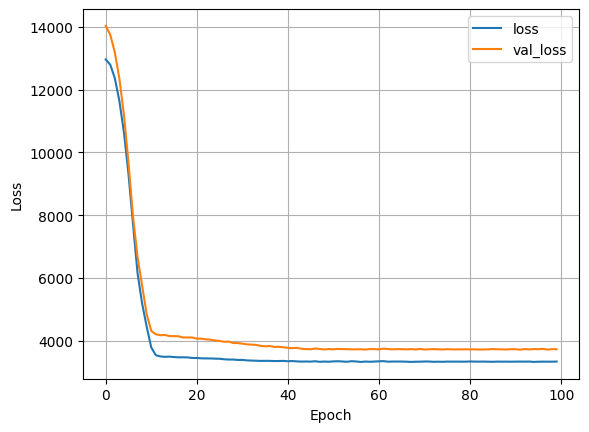

In [20]:
# plotting the loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

In [21]:
# evaluate the model
test_results = {}
test_results['model'] = model.evaluate(test_features, test_labels, verbose=0)
test_results

{'model': [3479.33935546875, 3479.33935546875, 47206800.0]}

## Predictions

9/9 - 0s - 4ms/step - loss: 3479.3394 - mae: 3479.3394 - mse: 47206800.0000
Testing set Mean Abs Error: 3479.34 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


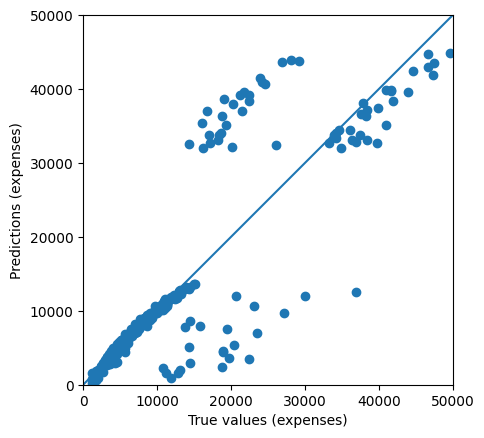

In [23]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_features, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
    print("You passed the challenge. Great job!")
else:
    print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)